# Implementing Multiclass Classification

In [1]:
# The goal of the project is to classify the complaint into a specific product
# category. Since it has multiple categories, it becomes a multiclass
# classification that can be solved through many of the machine learning
# algorithms.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from io import StringIO
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
Data = pd.read_csv("./consumer_complaints.csv",encoding='latin-1', low_memory=False)

In [9]:
Data.dtypes

date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [10]:
# Selecting required columns and rows
Data = Data[['product', 'consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

In [11]:
Data.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [16]:
# Factorizing the category column
Data['category_id'] = Data['product'].factorize()[0]
Data.head(10)

,product,consumer_complaint_narrative,category_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2
190237,Mortgage,Experian is reporting my OPEN and CURRENT Mort...,2
190238,Mortgage,This complaint is against Wells Fargo Bank for...,2
190251,Mortgage,I spoke to XXXX of green tree representatives ...,2
190263,Credit card,i opened XXXX Bank of America credit cards 15-...,3
190264,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...,1


In [17]:
# Check the distriution of complaints by category
Data.groupby('product').consumer_complaint_narrative.count()

product
Bank account or service     5711
Consumer Loan               3678
Credit card                 7929
Credit reporting           12526
Debt collection            17552
Money transfers              666
Mortgage                   14919
Other financial service      110
Payday loan                  726
Prepaid card                 861
Student loan                2128
Name: consumer_complaint_narrative, dtype: int64

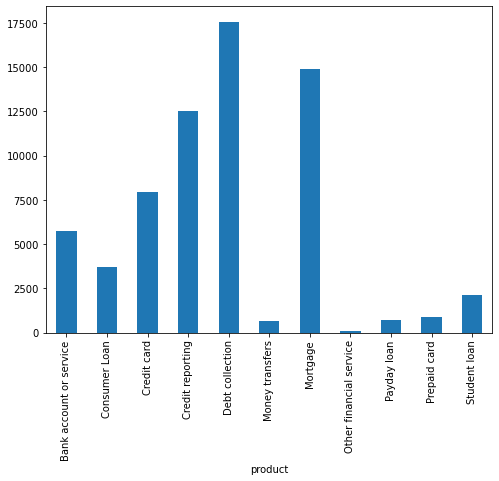

In [20]:
fig = plt.figure(figsize=(8,6))
Data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [22]:
# Split the data into train and validation:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(Data['consumer_complaint_narrative'], Data['product'])

# Feature engineering using TF-IDF

In [23]:
# Here we consider maximum features to be 5000.
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(Data['consumer_complaint_narrative'])
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

In [24]:
xvalid_tfidf

<16702x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1513942 stored elements in Compressed Sparse Row format>

In [25]:
xtrain_tfidf

<50104x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 4538616 stored elements in Compressed Sparse Row format>

In [46]:
# Model building and evaluation
model = linear_model.LogisticRegression(max_iter = 500, C = 0.5 )

In [47]:
model.get_params(deep=True)

{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [48]:
model.fit(xtrain_tfidf, train_y)

LogisticRegression(C=0.5, max_iter=500)

In [49]:
# Checking accuracy
accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf),
valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.841635732247635


In [53]:
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf),target_names=Data['product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.83      0.81      0.82      1449
          Consumer Loan       0.79      0.57      0.67       920
               Mortgage       0.79      0.80      0.80      1985
            Credit card       0.84      0.85      0.85      3070
       Credit reporting       0.81      0.90      0.85      4436
           Student loan       0.83      0.44      0.57       174
Bank account or service       0.92      0.96      0.93      3723
            Payday loan       0.00      0.00      0.00        35
        Money transfers       0.62      0.17      0.27       168
Other financial service       0.84      0.54      0.66       208
           Prepaid card       0.89      0.73      0.81       534

               accuracy                           0.84     16702
              macro avg       0.74      0.62      0.66     16702
           weighted avg       0.84      0.84      0.84     16702



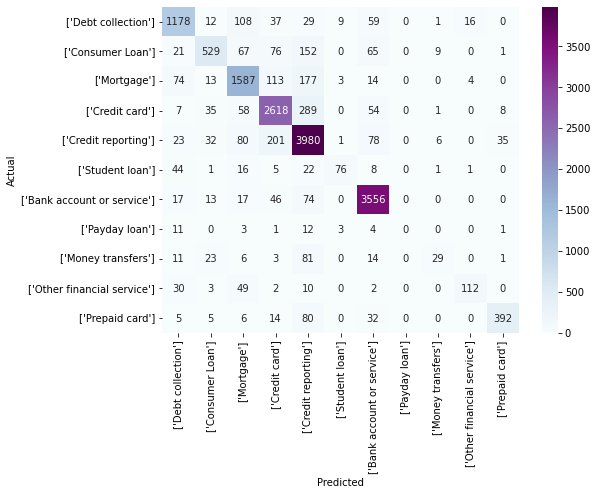

In [62]:
#confusion matrix
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tfidf))
# Vizualizing confusion matrix
category_id_df = Data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id','product']].values)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",
xticklabels=category_id_df[['product']].values,
yticklabels=category_id_df[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [59]:
# Prediction example
texts = ["This company refuses to provide me verification and validation of debt"+ "per my right under the FDCPA. I do not believe this debt is mine."]
text_features = tfidf_vect.transform(texts)
predictions = model.predict(text_features)
predictions[0]

4

In [63]:
print(texts)
print(" - Predicted as: '{}'".format(id_to_category[predictions[0]]))

['This company refuses to provide me verification and validation of debtper my right under the FDCPA. I do not believe this debt is mine.']
 - Predicted as: 'Credit reporting'


# Implementing Sentiment Analysis

In [ ]:
# vaderSentiment library
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [64]:
#Read the data
df = pd.read_csv('Reviews.csv')
# Look at the top 5 rows of the data
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [67]:
df.size

5684540

In [68]:
# Understand the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [73]:
df.describe

<bound method NDFrame.describe of             Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        Helpfulne

In [71]:
# Looking at the description of the reviews
df.Text.head(5)

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [74]:
# Text preprocessing

In [75]:
# Import libraries
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
# Lower casing and removing punctuations
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Text'] = df['Text'].str.replace('[^\w\s]','')   
df.Text.head(5)

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price there was a wide ...
Name: Text, dtype: object

In [76]:
# Removal of stop words
stop = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.Text.head(5)

0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanutsth...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

In [78]:
# Spelling correction  !! takes long time !! 
#df['Text'] = df['Text'].apply(lambda x: str(TextBlob(x).correct()))
#df.Text.head(5)

In [79]:
# Lemmatization
df['Text'] = df['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.Text.head(5)

0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanutsth...
2    confection around century light pillowy citrus...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

In [ ]:
# Exploratory data analysis

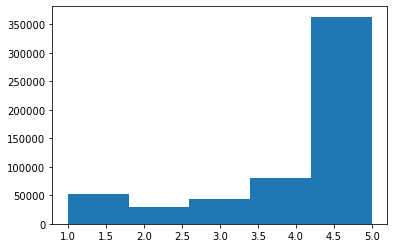

Score
1     52264
2     29743
3     42638
4     80655
5    363111
Name: Id, dtype: int64


In [80]:
# Create a new data frame "reviews" to perform exploratory data analysis upon that
reviews = df
# Dropping null values
reviews.dropna(inplace=True)
# The histogram reveals this dataset is highly unbalanced towards high rating.
reviews.Score.hist(bins=5,grid=False)
plt.show()
print(reviews.groupby('Score').count().Id)

In [81]:
# To make it balanced data, we sampled each score by the lowest
# n-count from above. (i.e. 29743 reviews scored as '2')
score_1 = reviews[reviews['Score'] == 1].sample(n=29743)
score_2 = reviews[reviews['Score'] == 2].sample(n=29743)
score_3 = reviews[reviews['Score'] == 3].sample(n=29743)
score_4 = reviews[reviews['Score'] == 4].sample(n=29743)
score_5 = reviews[reviews['Score'] == 5].sample(n=29743)


In [82]:
reviews_sample = pd.concat([score_1,score_2,score_3,score_4, score_5],axis=0)
reviews_sample.reset_index(drop=True,inplace=True)

In [83]:
print(reviews_sample.groupby('Score').count().Id)

Score
1    29743
2    29743
3    29743
4    29743
5    29743
Name: Id, dtype: int64


In [87]:
# !pip install wordcloud

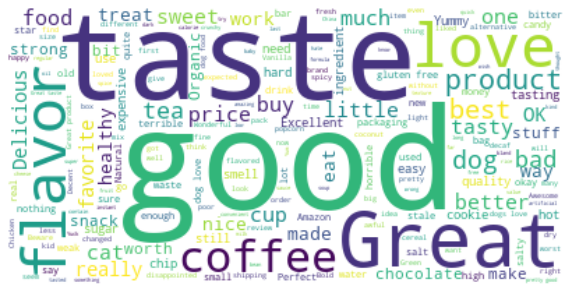

In [90]:
# wo# Wordcloud function's input needs to be a single string of text.rd cloud for 'Summary' text

# Wordcloud function's input needs to be a single string of text.
# concatenating all Summaries into a single string.

from wordcloud import WordCloud
reviews_str = reviews_sample.Summary.str.cat()
wordcloud = WordCloud(background_color='white').generate(reviews_str)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

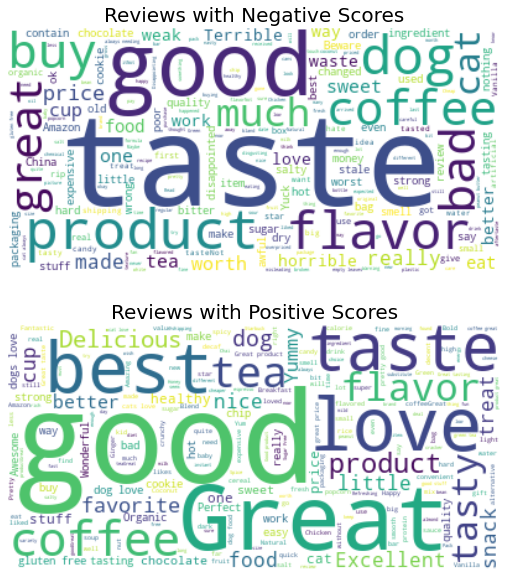

In [95]:
# Now let's split the data into Negative (Score is 1 or 2) and Positive (4 or #5) Reviews.
negative_reviews = reviews_sample[reviews_sample['Score'].isin([1,2]) ]
positive_reviews = reviews_sample[reviews_sample['Score'].isin([4,5]) ]

# Transform to single string
negative_reviews_str = negative_reviews.Summary.str.cat()
positive_reviews_str = positive_reviews.Summary.str.cat()

# Create wordclouds
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_str)
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews_str)

# Plot
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Reviews with Negative Scores',fontsize=20)
ax2 = fig.add_subplot(212)
ax2.imshow(wordcloud_positive,interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Reviews with Positive Scores',fontsize=20)
plt.show()

In [ ]:
# Feature engineering

# This step is not required as we are not building the model from scratch;
# rather we are using the pretrained model from the library vaderSentiment.
# If you want to build the model from scratch, you can leverage the
# above positive and negative classes created while exploring as a target
# variable and then training the model. You can follow the same steps as text
# classification explained to build a sentiment classifier from scratch.
# negative, and neutral created using score.
# • Score <= 2: Negative
# • Score = 3: Neutral
# • Score > =4: Positive

In [ ]:
# class

In [ ]:
# Sentiment scores

# Sentiment Analysis: Pretrained model takes the input from the text
# description and outputs the sentiment score ranging from -1 to +1 for each
# sentence.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import sys
import ast
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
plt.style.use('fivethirtyeight')

In [98]:
# Function for getting the sentiment
cp = sns.color_palette()
analyzer = SentimentIntensityAnalyzer()

# Generating sentiment for all the sentence present in the dataset
emptyline=[]
for row in df['Text']:
    vs=analyzer.polarity_scores(row)
    emptyline.append(vs)
    
# Creating new dataframe with sentiments
df_sentiments=pd.DataFrame(emptyline)
df_sentiments.head(5)

,neg,neu,pos,compound
0,0.000,0.503,0.497,0.9413
1,0.129,0.762,0.110,-0.1027
2,0.130,0.587,0.283,0.8532
3,0.000,0.854,0.146,0.4404
4,0.000,0.369,0.631,0.9468


In [104]:
# Merging the sentiments back to reviews dataframe
df_c = pd.concat([df.reset_index(drop=True), df], axis=1)
df_c.head(3)

In [105]:
# Convert scores into positive and negetive sentiments using some threshold
df_c['Sentiment'] = np.where(df_c['compound'] >= 0 , 'Positive', 'Negative')
df_c.head(5)

In [ ]:
# Business insights
result=df_c['Sentiment'].value_counts()
result.plot(kind='bar', rot=0,color='br');

In [ ]:
#Sample code snippet
result=df_c.groupby('ProductId')['Sentiment'].value_counts().unstack()
result[['Negative','Positive']].plot(kind='bar', rot=0,color='rb')

# Text Similarity Functions

In [ ]:
!pip install recordlinkage

In [ ]:
import recordlinkage

# use the inbuilt dataset from recordlinkage library
#import data set
from recordlinkage.datasets import load_febrl1
#create a dataframe - dfa
dfA = load_febrl1()
dfA.head()

In [ ]:
# Blocking

# reduce the comparison window and create record pairs
# Generate pairs only for records in the same block
# here blocking is done on the “Sndx-SN,” column which is nothing but the Soundex value of the surname column 
# There are many advanced blocking techniques, also, like the following:
# • Standard blocking
# • Single column
# • Multiple columns
# • Sorted neighborhood
# • Q-gram: fuzzy blocking
# • LSH
# • Canopy clustering

# let’s build the pairs
using the first name as the blocking index.
indexer = recordlinkage.BlockIndex(on='given_name')
pairs = indexer.index(dfA)
print (len(pairs))


In [ ]:
# Similarity matching and scoring
# This cell can take some time to compute.
# we compute the similarity scores on the columns like given name,
# surname, and address between the record pairs generated in the previous
# step. For columns like date of birth, suburb, and state, we are using the
# exact match as it is important for this column to possess exact records.
# We are using jarowinkler, but you can use any of the other similarity

compare_cl = recordlinkage.Compare()
compare_cl.string('given_name', 'given_name',method='jarowinkler', label='given_name')
compare_cl.string('surname', 'surname', method='jarowinkler',label='surname')
compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth')
compare_cl.exact('suburb', 'suburb', label='suburb')
compare_cl.exact('state', 'state', label='state')
compare_cl.string('address_1', 'address_1',method='jarowinkler',label='address_1')
features = compare_cl.compute(pairs, dfA)
features.sample(5)

In [ ]:
# Predicting  match or do not match using ECM – classifier

u# nsupervised learning method to calculate the probability that the records match.

# select all the features except for given_name since its our blocking key

features1 = features[['suburb','state','surname','date_of_birth','address_1']]

# Unsupervised learning – probabilistic
ecm = recordlinkage.ECMClassifier()
result_ecm = ecm.learn((features1).astype(int),return_type ='series')
result_ecm


In [ ]:
# The output clearly shows that “rec-183-dup-0” matches “rec-183-org”
# and can be linked to one global_id. What we have done so far is
# deduplication: identifying multiple records of the same users from the
# individual table.

# Summarizing Text Data

In [5]:
# Feature-based text summarization

# Install sumy
# !pip install sumy

In [1]:
# Import the packages
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.luhn import LuhnSummarizer

In [2]:
# Extracting and summarizing
LANGUAGE = "english"
SENTENCES_COUNT = 10
url="https://en.wikipedia.org/wiki/Natural_language_processing"
parser = HtmlParser.from_url(url, Tokenizer(LANGUAGE))
summarizer = LsaSummarizer()
summarizer = LsaSummarizer(Stemmer(LANGUAGE))
summarizer.stop_words = get_stop_words(LANGUAGE)


In [8]:
for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

[2] However, real progress was much slower, and after the ALPAC report in 1966, which found that ten-year-long research had failed to fulfill the expectations, funding for machine translation was dramatically reduced.
However, there is an enormous amount of non-annotated data available (including, among other things, the entire content of the World Wide Web), which can often make up for the inferior results if the algorithm used has a low enough time complexity to be practical.
The machine-learning paradigm calls instead for using statistical inference to automatically learn such rules through the analysis of large corpora(the plural form of corpus, is a set of documents, possibly with human or computer annotations) of typical real-world examples.
Increasingly, however, research has focused on statistical models, which make soft, probabilistic decisions based on attaching real-valued weights to each input feature (complex-valued embeddings,[17] and neural networks in general have also 

# Clustering Documents

In [4]:
# !pip install mpld3

In [17]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
from nltk import stem

In [27]:
#Lets use the same complaint dataset we use for classification
Data = pd.read_csv("./Consumer_Complaints.csv",encoding='latin-1',low_memory=False)
#selecting required columns and rows
Data = Data[['consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]
# lets do the clustering for just 200 documents. Its easier to interpret.
Data_sample=Data.sample(200)

In [28]:
Data_sample

,consumer_complaint_narrative
326000,"XXXX XXXX, 2015 I have had misunderstandings w..."
273528,I bought couple of prepaid cards at XXXX in XX...
523425,I applied online for a personal loan ( to help...
221227,To Whom It May Concern : I received an alert b...
243713,This debt is not mine. I have a son with a sim...
...,...
232229,"I received the letter from "" Discover Financia..."
514701,My daughter stole my debit card on several occ...
206854,I did not receive this service that I am being...
513960,"On XXXX XXXX XXXX, Ocwen mistakenly applied my..."


In [29]:
# Preprocessing and TF-IDF feature engineering

# Remove unwanted symbol
Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX','')
# Convert dataframe to list
complaints = Data_sample['consumer_complaint_narrative'].tolist()
# create the rank of documents – we will use it later
ranks = []
for i in range(1, len(complaints)+1):
    ranks.append(i)


In [30]:
# Stop Words
stopwords = nltk.corpus.stopwords.words('english')
# Load 'stemmer'
stemmer = SnowballStemmer("english")


In [31]:
# Functions for sentence tokenizer, to remove numeric tokens and raw #punctuation
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, stop_words='english',
use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [33]:
#fit the vectorizer to data
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names_out ()
print(tfidf_matrix.shape)


C:\Users\pooya\anaconda3\envs\NLP\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


(200, 37)


In [45]:
terms

array(["'s", 'account', 'ani', 'ask', 'bank', 'becaus', 'card', 'charg',
       'collect', 'compani', 'contact', 'credit', 'credit report', 'day',
       'debt', 'did', 'help', 'inform', 'letter', 'loan', 'month', "n't",
       'number', 'onli', 'paid', 'pay', 'payment', 'phone', 'receiv',
       'remov', 'report', 'request', 'sent', 'state', 'time', 'told',
       'year'], dtype=object)

In [35]:
# Clustering using K-means 

#Import Kmeans
from sklearn.cluster import KMeans
# Define number of clusters
num_clusters = 6
#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

#final clusters
clusters = km.labels_.tolist()
complaints_data = { 'rank': ranks, 'complaints': complaints,'cluster': clusters }
frame = pd.DataFrame(complaints_data, index = [clusters] , columns = ['rank', 'cluster'])
frame


,rank,cluster
3,1,3
0,2,0
5,3,5
0,4,0
4,5,4
...,...,...
0,196,0
0,197,0
3,198,3
5,199,5


In [36]:
#number of docs per cluster
frame['cluster'].value_counts()

3    44
1    40
5    36
4    31
2    25
0    24
Name: cluster, dtype: int64

In [46]:
# Identify cluster behavior
# Identify which are the top 5 words that are nearest to the cluster centroid.

totalvocab_stemmed = []
totalvocab_tokenized = []

for i in complaints:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized},index = totalvocab_stemmed)

        
vocab_frame

,words
i,i
have,have
had,had
misunderstand,misunderstandings
with,with
...,...
garnish,garnished
my,my
wage,wages
by,by


In [53]:
#for i in range(num_clusters):
#    print("Cluster %d words:" % i, end='')
#    for ind in order_centroids[i, :6]:
#        print(' %s' % vocab_frame.iloc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
#        print()

In [54]:
# Plot the clusters on a 2D graph

#Similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(similarity_distance) # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
#Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3',
3: '#e7298a', 4: '#66a61e', 5: '#D2691E'}

#set up cluster names using a dict
cluster_names = {0: 'property, based, assist',
                1: 'business, card',
                2: 'authorized, approved, believe',
                3: 'agreement, application,business',
                4: 'closed, applied, additional',
                5: 'applied, card'}


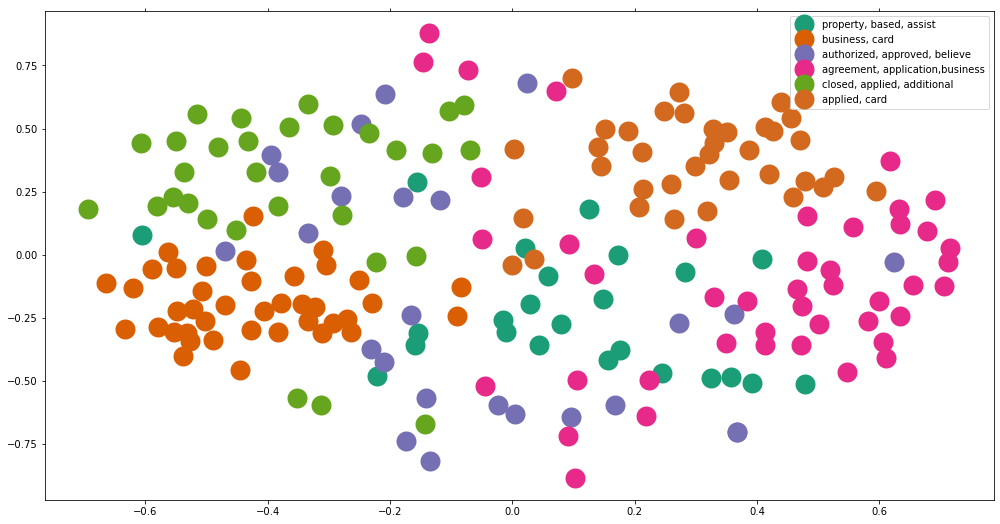

In [55]:
# Finally plot it
%matplotlib inline

#Create data frame that has the result of the MDS and the cluster
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))

groups = df.groupby('label')

# Set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
    axis= 'x',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off')
    ax.tick_params(\
    axis= 'y',
    which='both',
    left='off',
    top='off',
    labelleft='off')
    
ax.legend(numpoints=1)
plt.show()